In [ ]:
# Mounting Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models
from torchvision.models import vit_b_16
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import pandas as pd
import os

In [ ]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# ResNet18 with pretrained weights and adjusted learning rate
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(dataset.classes))
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)

# advanced data augmentations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  # Data augmentation
    transforms.RandomRotation(10),    # Data augmentation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 222MB/s]


In [ ]:
# Load dataset (Dataset contains only 'Benign' and 'Malignant' folders)
dataset_path = "/content/drive/MyDrive/2. AI ML Projects + Datasets/train_cancer"
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

In [ ]:
# Split dataset into train (70%), validation (20%), and test (10%)
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False) # Validation dataloader
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

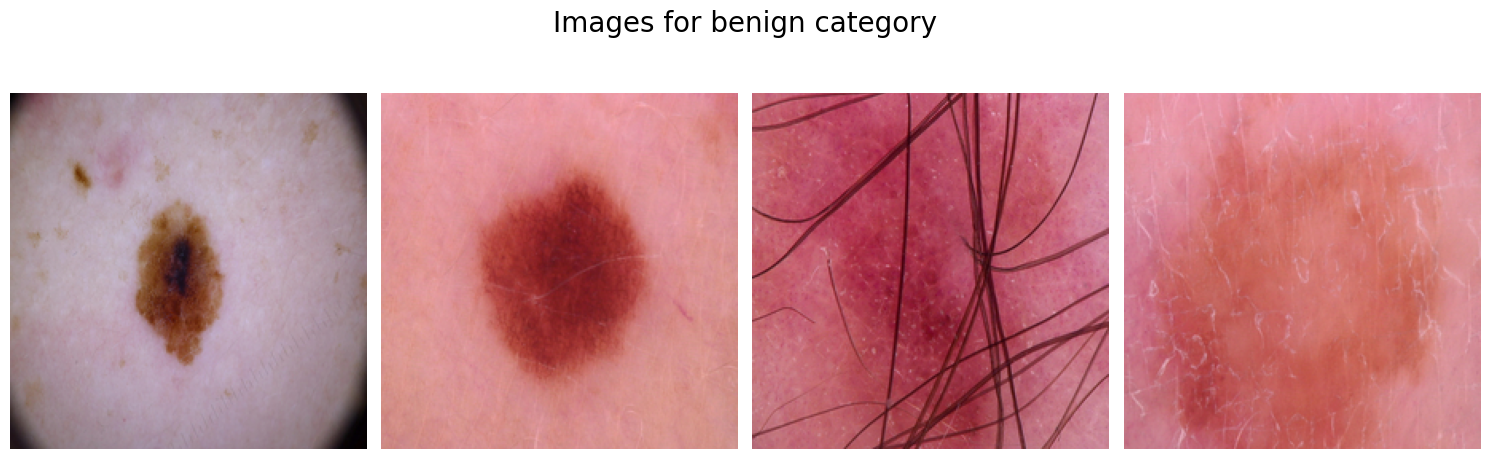

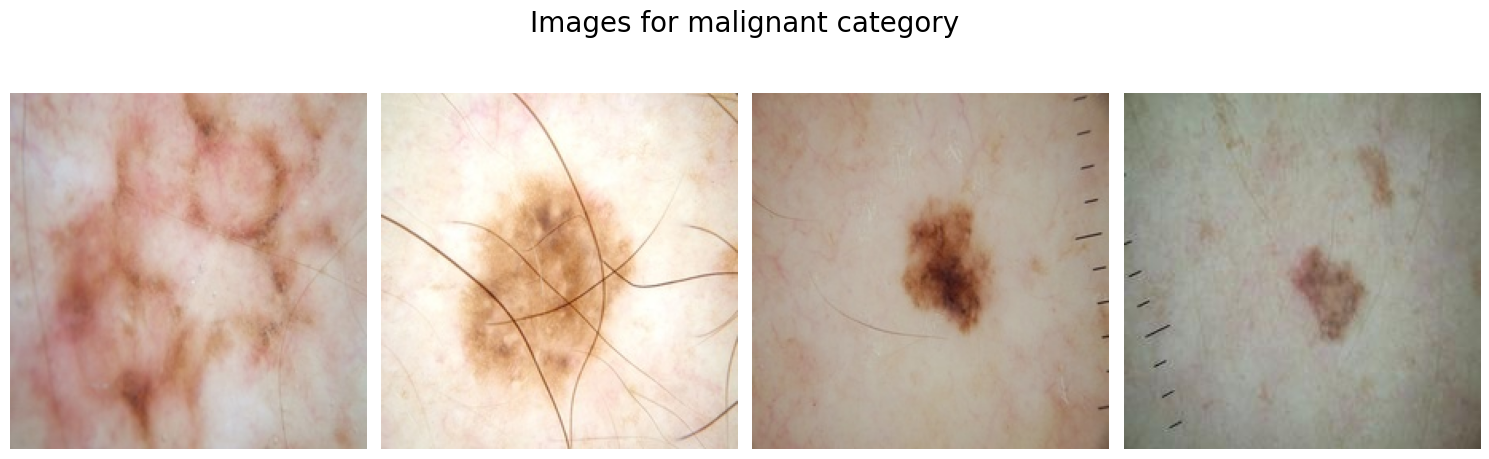

In [ ]:
# Visualizing sample images
def visualize_samples(dataset, num_images=4):
    class_names = dataset.classes  # Use dataset.dataset to access original class names
    df = pd.DataFrame(dataset.imgs, columns=['image_path', 'label'])
    df['label'] = df['label'].apply(lambda x: class_names[x])

    for cat in df['label'].unique():
        temp = df[df['label'] == cat]
        index_list = temp.index
        fig, ax = plt.subplots(1, num_images, figsize=(15, 5))
        fig.suptitle(f'Images for {cat} category', fontsize=20)
        for i in range(num_images):
            index = np.random.randint(0, len(index_list))
            index = index_list[index]
            image_path = df.iloc[index]['image_path']
            img = np.array(Image.open(image_path))
            ax[i].imshow(img)
            ax[i].axis("off")
        plt.tight_layout()
        plt.show()

visualize_samples(dataset)

In [ ]:
class ViTWithDropout(nn.Module):
          def __init__(self, num_classes):
              super(ViTWithDropout, self).__init__()
              self.vit = vit_b_16(pretrained=True)
              num_ftrs = self.vit.heads.head.in_features
              self.vit.heads.head = nn.Sequential(
                  nn.Dropout(0.3),
                  nn.Linear(num_ftrs, 512), # Increased neurons
                  nn.ReLU(),
                  nn.Dropout(0.3),
                  nn.Linear(512, 256), # Added layer
                  nn.ReLU(),
                  nn.Dropout(0.3),
                  nn.Linear(256, num_classes)
              )

          def forward(self, x):
              return self.vit(x)

In [ ]:
# Model, Loss, and Optimizer
model = ViTWithDropout(num_classes=len(dataset.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

In [ ]:
# Training loop with validation and early stopping
epochs = 10
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

best_val_loss = float('inf')
patience = 5  # Number of epochs to wait for improvement
early_stop_counter = 0

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct / total * 100
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # Validation step
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_correct += predicted.eq(labels).sum().item()
            val_total += labels.size(0)

    val_epoch_loss = val_loss / len(val_loader)
    val_epoch_accuracy = val_correct / val_total * 100
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_accuracy)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_accuracy:.2f}%, Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_accuracy:.2f}%")
    # Check for early stopping
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break  # Exit the training loop


Epoch 1/10, Train Loss: 0.5211, Train Acc: 75.13%, Val Loss: 0.2619, Val Acc: 94.44%
Epoch 2/10, Train Loss: 0.4273, Train Acc: 86.77%, Val Loss: 0.1871, Val Acc: 94.44%
Epoch 3/10, Train Loss: 0.3067, Train Acc: 87.30%, Val Loss: 0.2058, Val Acc: 96.30%
Epoch 4/10, Train Loss: 0.2906, Train Acc: 90.48%, Val Loss: 0.2928, Val Acc: 90.74%
Epoch 5/10, Train Loss: 0.2245, Train Acc: 93.12%, Val Loss: 0.1343, Val Acc: 98.15%
Epoch 6/10, Train Loss: 0.2302, Train Acc: 92.59%, Val Loss: 0.1004, Val Acc: 98.15%
Epoch 7/10, Train Loss: 0.1787, Train Acc: 93.12%, Val Loss: 0.1086, Val Acc: 96.30%
Epoch 8/10, Train Loss: 0.1595, Train Acc: 93.65%, Val Loss: 0.0753, Val Acc: 100.00%
Epoch 9/10, Train Loss: 0.1653, Train Acc: 94.71%, Val Loss: 0.0667, Val Acc: 98.15%
Epoch 10/10, Train Loss: 0.1765, Train Acc: 95.24%, Val Loss: 0.0707, Val Acc: 98.15%


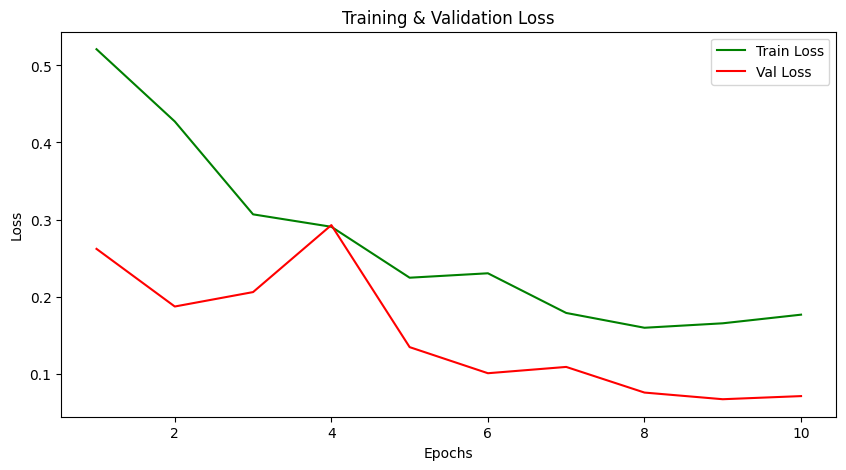

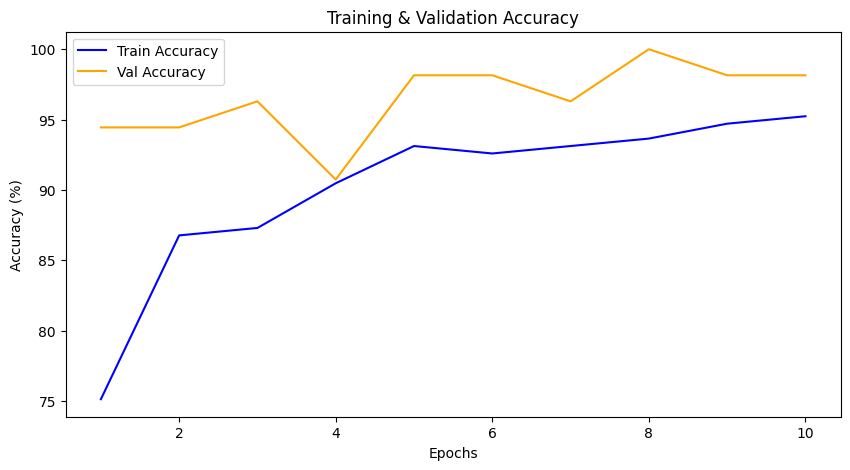

In [ ]:
# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, 'g-', label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, 'r-', label='Val Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, 'b-', label='Train Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, color='orange', linestyle='-', label='Val Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model on test data
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

print(f"Test Accuracy: {correct/total*100:.2f}%")

Test Accuracy: 96.30%
